# LSN Exercise 6

In this numerical exercise we are going to compute some **ensemble properties of a 1D Ising model** via Monte Carlo simulations, using two different sampling algorithms: **Metropolis** and **Gibbs**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Settings for plots:

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
SCALE = 6
FIG_SIZE = (SCALE*0.5*(1+np.sqrt(5)), SCALE)

# Declarations for expected plots:

points=100
T = np.linspace(0.2,3.0,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th

# Function for reading:

def read_observables(filename, n_blocks, obs, err):
    with open(filename) as f:
        appo2 = []
        appo = f.read().splitlines()
        for i in range(1,len(appo)+1):
            if i%n_blocks==0:
                appo2.append(appo[i-1].split())
                
    for i in range(len(appo2)):
        obs.append(float(appo2[i][2]))
        err.append(float(appo2[i][3]))
        
# -----------------------------------------------

# Temperature range

temp = [round(0.10*i,2) for i in range(5, 26)]

## 6.1 Sampling algorithms 

The hamiltonian of the system is:

$$ H = -J\sum_{i=1}^N s_i s_{i+1} - \frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1}) $$

where we set $N=50$ and $J=1$. At fixed temperature $T$ any particular configuration of the system occurs with probability proportional to the *Boltzmann weight*:

$$ p(\{s_i\}) \propto e^{-\beta H} $$

To sample 1D lattice configurations according to this non-normalized distribution, we can adopt two different algorithms:

- **Metropolis sampling** (or *M(RT)^2*): starting from the previous configuration, we *try to flip a randomly chosen spin with probability*:

  $$ e^{-\beta(E_{new} - E_{old})} $$

  where energies are evaluated based on the interaction of the spin with *nearest neighbors*:

  $$ E = - J s_t (s_{t-sx} + s_{t-dx}) - h s_t $$

  with $s_t$ the selected spin and $s_{t-sx}$, $s_{t-dx}$ the left and right neighbors; $E_{old}$ has the current value of $s_t$, $E_{new}$ the flipped one. A MC step will consist in the attempt to to flip $N$ randomly selected spins.
  

- **Gibbs sampling** (or *"heat bath method"*): starting from the previous configuration, we randomly select a spin in the chain and we compute the probability of being up or down based on the configuration of the nearest neighbours*:

  $$ p_{up} = \dfrac{e^{-\beta E_+}}{e^{-\beta E_+} + e^{-\beta E_-}} = \dfrac{1}{1 + e^{-\beta (E_- - E_+)}} $$
  
  where $E_+$ and $E_-$ are the energies of the up and down configurations. Like in the Metropolis case this procedure is repeated over $N$ spins.

Our C++ code implement the two sampling techniques and compute ensemble averages using data-blocking method. At the beginning of every simulation we fix (writing the `input.dat` file):

- the system parameters: $J$, $h$, $N$;
- the temperature $T$;
- the sampling technique (*boolean* `metro`); 
- the total number of MC steps and the number of blocks.

To equilibrate the sample we added the possibility to start from an old configuration via the *boolean* `should_old`, which enables the reading of `config.0` to start from a specific configuration. The *boolean* `should_equi` simply determines wether the simulation is an equilibration attempt or a "real" simulation: the otput files will have different names depending on the value of `should_equi`. Having fixed all the ensemble parameters in the *input file*, an equilibration followed by a "measurement" simulation requires:

- `should_old = 0` and `should_equi = 1` in `input.dat`;
- `cp config.final config.0`;
- `should_old = 1` and `should_equi = 0` in `input.dat`;

The typical routine consists in $n_{eq}=1000$ equilibration steps followed by $M=10^5$ MC steps decomposed in $N=20$ blocks. For every simulation we save the equilibrated configuration and we use this as the starting point for the true one, during which we estimate ensemble averages and errors progressively in the number of blocks. A `walker` vector stores the total energy, the total spin value and the squares of these quantities for each step, later accumulated in another vector to compute averages and squared averages in each block.

## 6.2 Energy

We fix $N=50$, $J=1$ and $h=0$. The **internal energy** of the system is simply the *expectation value of the hamiltonian*, in this case reduced to the form:

$$ H = -J\sum_{i=1}^N s_i s_{i+1} $$

to obtain $U=U(T)$ we need to simulate our system at different temperatures: we consider the interval of *reduced temperatures* $[0.5,2.5]$ and we use a step of $0.1$, for a total of $20$ points. In the following plot we show the comparison between Metropolis and Gibbs sampling. For clarity we report in a table all the averages and errors for both sampling techniques: the perfect agreement makes the two indistinguishable from each other and from the exact curve.

,Temp,$ \dfrac{\mathscr E}{N} $ M(RT)^2,Errors M(RT)^2,$ \dfrac{\mathscr E}{N} $ Gibbs,Errors Gibbs
Blocks,,,,,
0,0.5,-0.974299,0.000372,-0.973983,0.000608
1,0.6,-0.935011,0.000266,-0.935423,0.000420
2,0.7,-0.892589,0.000242,-0.892239,0.000290
3,0.8,-0.848434,0.000257,-0.848533,0.000241
4,0.9,-0.804557,0.000190,-0.804657,0.000194
5,1.0,-0.761247,0.000150,-0.761728,0.000157
6,1.1,-0.720975,0.000124,-0.720991,0.000153
7,1.2,-0.682449,0.000106,-0.682469,0.000147
8,1.3,-0.646434,0.000150,-0.646619,0.000144


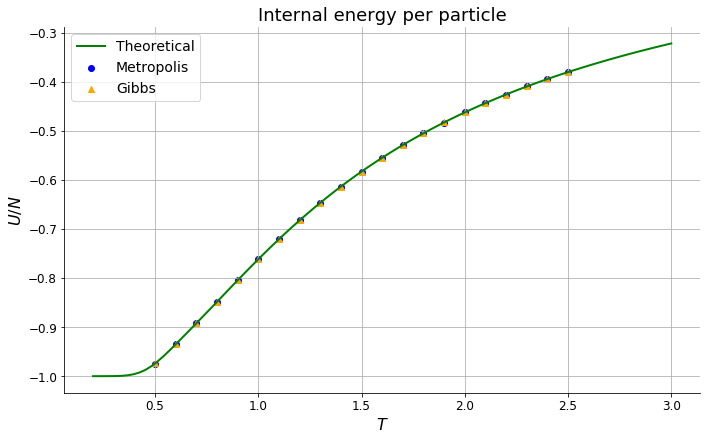

In [2]:
# internal energy per particle

energy_true = -J*( th + ch*thN )/( 1 + thN )

# ----------------------------------------------
energy_metr = []
error_metr = []
energy_gib = []
error_gib = []

read_observables("output_metro/output.ene.metro", 20, energy_metr, error_metr)
read_observables("output_gibbs/output.ene.gibbs", 20, energy_gib, error_gib)

data = {'Temp': temp, '$ \dfrac{\mathscr E}{N} $ M(RT)^2': energy_metr, 'Errors M(RT)^2': error_metr, 
        '$ \dfrac{\mathscr E}{N} $ Gibbs': energy_gib, 'Errors Gibbs': error_gib}
data = pd.DataFrame(data)
data.index.name = 'Blocks'
display(data)

plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(T, energy_true, color='green', label="Theoretical")
plt.scatter(temp, energy_metr, color='blue', marker = 'o', label='Metropolis')
plt.scatter(temp, energy_gib, color='orange', marker = '^', label='Gibbs')
plt.title("Internal energy per particle")
plt.xlabel('$ T $')
plt.ylabel('$ U/N $')
plt.legend()
plt.grid()

## 6.3 Heat Capacity

Again fixing $N=50$, $J=1$ and $h=0$ we estimate the **heat capacity** using the *link between energy fluctuations and energy dissipation*:

$$ \frac{C}{N} = \frac{k_B \beta^2}{N} \left(\langle H^2 \rangle - \langle H \rangle^2 \right) \equiv \frac{k_B \beta^2}{N} \sigma^2_E $$

Thus the only quantity to compute in addition from the internal energy is the average of the squares, and this is done straightforwardly. We obtain again a perfect agreement between the two sampling algorithms.

,Temperature,$ \dfrac{\mathcal C}{N} $ M(RT)^2,Errors M(RT)^2,$ \dfrac{\mathcal C}{N} $ Gibbs,Errors Gibbs
Blocks,,,,,
0,0.5,0.327033,0.003033,0.330432,0.004435
1,0.6,0.423701,0.001552,0.421911,0.002212
2,0.7,0.433998,0.001044,0.430437,0.001956
3,0.8,0.439556,0.001252,0.439241,0.001427
4,0.9,0.436375,0.000743,0.435333,0.001005
5,1.0,0.421103,0.000762,0.420414,0.000910
6,1.1,0.396653,0.000664,0.397035,0.000516
7,1.2,0.370848,0.000408,0.371039,0.000530
8,1.3,0.343785,0.000485,0.344229,0.000358


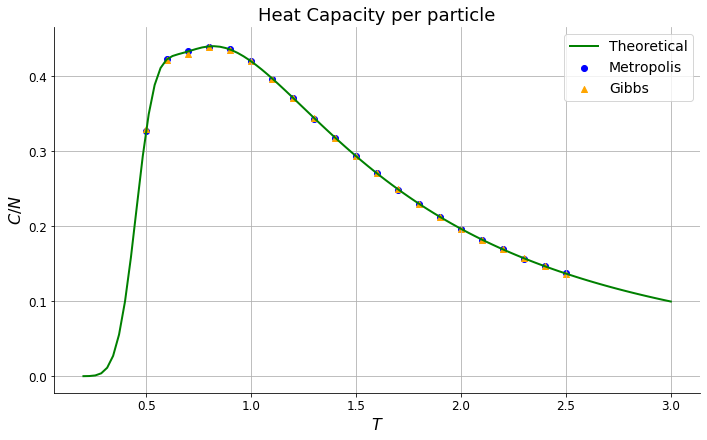

In [3]:
# heat capacity per particle

heat_true = ((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)

# ----------------------------------------------------------------------------------------------------------
heat_metr = []
error_metr = []
heat_gib = []
error_gib = []

read_observables("output_metro/output.heat.metro", 20, heat_metr, error_metr)
read_observables("output_gibbs/output.heat.gibbs", 20, heat_gib, error_gib)

data = {'Temperature': temp, '$ \dfrac{\mathcal C}{N} $ M(RT)^2': heat_metr, 'Errors M(RT)^2': error_metr, 
        '$ \dfrac{\mathcal C}{N} $ Gibbs': heat_gib, 'Errors Gibbs': error_gib}
data = pd.DataFrame(data)
data.index.name = 'Blocks'
display(data)

plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(T, heat_true, color='green', label="Theoretical")
plt.scatter(temp, heat_metr, color='blue', marker = 'o', label='Metropolis')
plt.scatter(temp, heat_gib, color='orange', marker = '^', label='Gibbs')
plt.title("Heat Capacity per particle")
plt.xlabel('$ T $')
plt.ylabel('$ C/N $')
plt.legend()
plt.grid()

## 6.4 Magnetization

The **magnetization** is the average value of the sum of the spin values:

$$ \frac{M}{N} = m = \frac{1}{N} \, \left\langle \sum_{i=1}^N s_i \right\rangle $$

This quantity fluctuates around zero in absence of external field. Setting $N=50$, $J=1$ and $h=0.02$ we follow the same route as before; we get perfect agreement in the range of temperatures adopted.

,Temperature,$ \dfrac{\mathcal M}{N} $ M(RT)^2,Errors M(RT)^2,$ \dfrac{\mathcal M}{N} $ Gibbs,Errors Gibbs
Blocks,,,,,
0,0.5,0.889146,0.005320,0.885786,0.006405
1,0.6,0.665314,0.004697,0.675010,0.008822
2,0.7,0.441554,0.004814,0.439840,0.006127
3,0.8,0.294639,0.003015,0.293503,0.004205
4,0.9,0.198298,0.001755,0.200593,0.002709
5,1.0,0.145301,0.001613,0.144947,0.002000
6,1.1,0.112763,0.001190,0.109570,0.001465
7,1.2,0.086950,0.000780,0.086598,0.001140
8,1.3,0.071687,0.000972,0.069537,0.000901


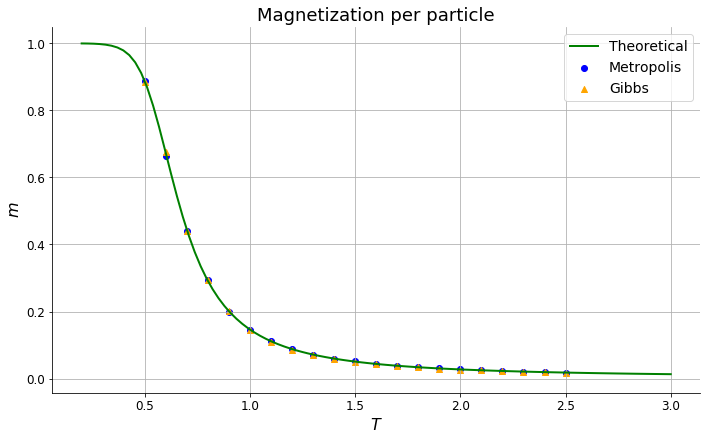

In [4]:
# external field on

h = 0.02
b = beta

# magnetization per particle

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
mag_true = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

# -------------------------------------------------------------------------------------------------------------------------------------------------
mag_metr = []
error_metr = []
mag_gib = []
error_gib = []

read_observables("output_metro/output.mag.metro", 20, mag_metr, error_metr)
read_observables("output_gibbs/output.mag.gibbs", 20, mag_gib, error_gib)

data = {'Temperature': temp, '$ \dfrac{\mathcal M}{N} $ M(RT)^2': mag_metr, 'Errors M(RT)^2': error_metr, 
        '$ \dfrac{\mathcal M}{N} $ Gibbs': mag_gib, 'Errors Gibbs': error_gib}
data = pd.DataFrame(data)
data.index.name = 'Blocks'
display(data)

plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(T, mag_true, color='green', label="Theoretical")
plt.scatter(temp, mag_metr, color='blue', marker = 'o', label='Metropolis')
plt.scatter(temp, mag_gib, color='orange', marker = '^', label='Gibbs')
plt.title("Magnetization per particle")
plt.xlabel('$ T $')
plt.ylabel('$ m $')
plt.legend()
plt.grid()

## 6.5 Susceptibility

Finally, the **susceptibility** of the system is given by:

$$ \frac{\chi}{N} = \frac{\beta}{N} \left\langle \left( \sum_{i=1,N}s_i \right)^2 \right\rangle $$

We run our simulations setting $N=50$, $J=1$ and $h=0$.

,Temperature,$ \dfrac{\chi}{N} $ M(RT)^2,Errors M(RT)^2,$ \dfrac{\chi}{N} $ Gibbs,Errors Gibbs
Blocks,,,,,
0,0.5,79.203900,0.353216,78.992100,0.589418
1,0.6,44.126700,0.219311,44.458300,0.301385
2,0.7,24.950200,0.129553,24.569400,0.144771
3,0.8,15.249500,0.093499,15.164200,0.079698
4,0.9,10.338600,0.034330,10.208600,0.055283
5,1.0,7.398230,0.029813,7.378280,0.025410
6,1.1,5.633050,0.015830,5.592820,0.019398
7,1.2,4.413010,0.014037,4.404830,0.012383
8,1.3,3.574070,0.009236,3.583560,0.005829


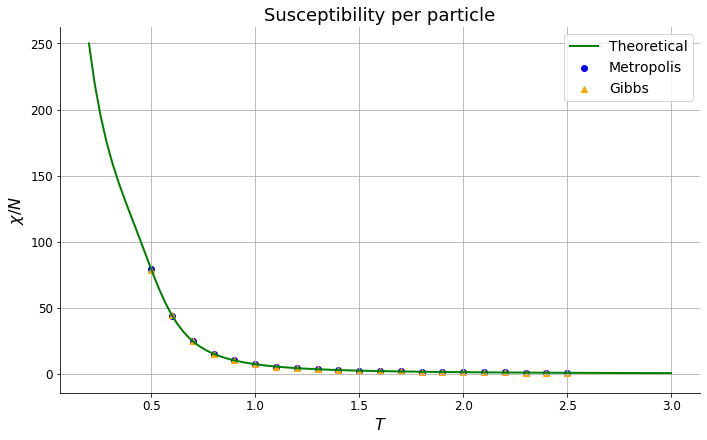

In [5]:
# Susceptibility

X_true = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

# ------------------------------------------------
X_metr = []
error_metr = []
X_gib = []
error_gib = []

read_observables("output_metro/output.chi.metro", 20, X_metr, error_metr)
read_observables("output_gibbs/output.chi.gibbs", 20, X_gib, error_gib)

data = {'Temperature': temp, '$ \dfrac{\chi}{N} $ M(RT)^2': X_metr, 'Errors M(RT)^2': error_metr, 
        '$ \dfrac{\chi}{N} $ Gibbs': X_gib, 'Errors Gibbs': error_gib}
data = pd.DataFrame(data)
data.index.name = 'Blocks'
display(data)

plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(T, X_true, color='green', label="Theoretical")
plt.scatter(temp, X_metr, color='blue', marker = 'o', label='Metropolis')
plt.scatter(temp, X_gib, color='orange', marker = '^', label='Gibbs')
plt.title("Susceptibility per particle")
plt.xlabel('$ T $')
plt.ylabel('$ \chi /N $')
plt.legend()
plt.grid()